In [1]:
import torch
import numpy as np
from pathlib import Path
import argparse
from neuralop.models import UNO
from magplot.base import create_mesh, mag_plotter
import pyvista as pv
pv.start_xvfb()
pv.set_jupyter_backend('static')

import matplotlib.pyplot as plt

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

from rtmag.test.analytical_field import get_analytic_b_field

from rtmag.test.eval_plot import plot_sample, plot_validation

from rtmag.test.eval import evaluate

from tqdm import tqdm
from torch.optim import Adam
import gc
from rtmag.train.diff_torch_batch import curl, divergence
from torchmetrics.regression import ConcordanceCorrCoef, MeanSquaredError

In [2]:
b_cube = get_analytic_b_field(n=1, m=1, l=0.3, psi=np.pi / 4).astype(np.float32)

In [3]:
b_cube.shape

(64, 64, 64, 3)

In [4]:
b_bottom = b_cube[:, :, 0, :]
b_bottom.shape

(64, 64, 3)

(512, 256, 3)


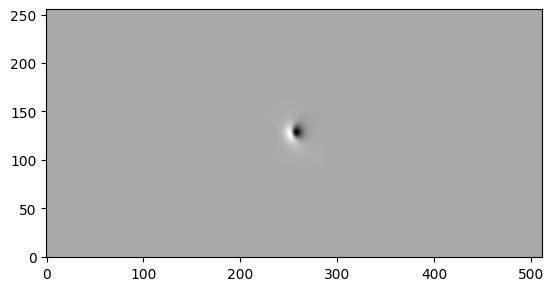

In [5]:
b_bottom_padding = np.pad(b_bottom, pad_width=[(224, 224), (96, 96), (0, 0)], mode='constant', constant_values=0)
print(b_bottom_padding.shape)
plt.imshow(b_bottom_padding[:, :, 2].T, origin='lower', cmap='gray')

In [6]:
b_bottom_padding[224:512-224, 96:256-96, :].shape

(64, 64, 3)

In [7]:
np.allclose(b_bottom_padding[224:512-224, 96:256-96, :], b_bottom)

True

In [8]:
meta_path = Path("/home/usr/workspace/base/uno_pi_cc_hnorm_1_unit_aug_ccc_square")
checkpoint = torch.load(meta_path / "best_model.pt", map_location=device)

args = argparse.Namespace()
info = np.load(meta_path / 'args.npy', allow_pickle=True).item()
for key, value in info.items():
        args.__dict__[key] = value

# b_norm = args.data["b_norm"]

model = UNO(
        hidden_channels = args.model["hidden_channels"],
        in_channels = args.model["in_channels"],
        out_channels = args.model["out_channels"],
        lifting_channels = args.model["lifting_channels"],
        projection_channels = args.model["projection_channels"],
        n_layers = args.model["n_layers"],

        factorization = args.model["factorization"],
        implementation = args.model["implementation"],
        rank = args.model["rank"],

        uno_n_modes = args.model["uno_n_modes"], 
        uno_out_channels = args.model["uno_out_channels"],
        uno_scalings = args.model["uno_scalings"],
    ).to(device)

checkpoint = torch.load(meta_path / 'best_model.pt')

model.load_state_dict(checkpoint['model_state_dict'])

<All keys matched successfully>

In [9]:
model_input = b_bottom_padding
model_input = model_input[None, :, :, None, :]
b_norm = np.max(np.abs(model_input))
print(b_norm)
model_input = model_input.transpose(0, 3, 2, 1, 4) / b_norm
model_input = torch.from_numpy(model_input).to(device) 
model_input.shape

293.32474


torch.Size([1, 1, 256, 512, 3])

In [10]:
labels = model(model_input).detach()
labels.shape

torch.Size([1, 256, 256, 512, 3])

In [11]:
model = model.train()
optimizer = Adam(model.parameters(), lr=args.training['learning_late'])

with tqdm(range(200)) as tqdm_loader_train:
        for iteration in tqdm_loader_train:
                gc.collect()
                torch.cuda.empty_cache()

                loss = {}
                # [b, z, y, x, 3] 
                outputs = model(model_input).to(device)

                # [b, z, y, x, 3] -> [b, z, ...]
                opts = torch.flatten(outputs, start_dim=2)
                lbls = torch.flatten(labels, start_dim=2)

                # [b, z, ...] -> [b, ..., z]
                opts = torch.permute(opts, (0, 2, 1))
                lbls = torch.permute(lbls, (0, 2, 1))

                # mse loss
                mse = MeanSquaredError().to(device)
                loss_mse = torch.mean(mse(opts.flatten(), lbls.flatten()))
                loss['mse'] = loss_mse

                # ccc loss
                # ccc = ConcordanceCorrCoef(num_outputs=opts.shape[-1]).to(device)
                # loss_ccc = 0.0
                # if args.training.get('ccc_square', False):
                #         for i in range(opts.shape[0]):
                #                 loss_ccc += torch.mean(torch.square(1.0 - ccc(opts[i], lbls[i])))
                # else:
                #         for i in range(opts.shape[0]):
                #                 loss_ccc += torch.mean(torch.abs(1.0 - ccc(opts[i], lbls[i])))
                # loss_ccc /= opts.shape[0]
                # loss['ccc'] = loss_ccc
                
                # [b, z, y, x, 3] -> [b, x, y, z, 3]
                b = torch.permute(outputs, (0, 3, 2, 1, 4))
                B = torch.permute(labels, (0, 3, 2, 1, 4))


                # unnormalization
                if args.data["dataset_name"] == "Hnorm_Square_Unit_Aug":
                        divisor = (1 / np.arange(1, b.shape[2] + 1)**2 ).reshape(1, 1, -1, 1).astype(np.float32)
                else:
                        divisor = (1 / np.arange(1, b.shape[2] + 1)).reshape(1, 1, -1, 1).astype(np.float32)
                        
                divisor = torch.from_numpy(divisor).to(device)
                b = b * divisor
                B = B * divisor
                
                # boundary condition loss
                loss_bc = 0.0
                # bottom (z=0)
                loss_bc += torch.mean(torch.square(b[:, :, :, 0, :] - B[:, :, :, 0, :]))
                loss['bc'] = loss_bc

                dx = torch.from_numpy(np.array([1.0]).astype(np.float32)).reshape(-1, 1)[None, ...].to(device)
                dy = torch.from_numpy(np.array([1.0]).astype(np.float32)).reshape(-1, 1)[None, ...].to(device)
                dz = torch.from_numpy(np.array([1.0]).astype(np.float32)).reshape(-1, 1)[None, ...].to(device)

                # force-free loss
                bx, by, bz = b[..., 0], b[..., 1], b[..., 2]
                jx, jy, jz = curl(bx, by, bz, dx, dy, dz)
                b = torch.stack([bx, by, bz], -1)
                j = torch.stack([jx, jy, jz], -1)

                jxb = torch.cross(j, b, -1)
                loss_ff = (jxb**2).sum(-1) / ((b**2).sum(-1) + 1e-7)
                loss_ff = torch.mean(loss_ff)
                loss['ff'] = loss_ff

                # divergence-less loss
                div_b = divergence(bx, by, bz, dx, dy, dz)
                loss_div = torch.mean(torch.square(div_b))
                loss['div'] = loss_div


                los = 0.01*args.training['w_mse']*loss['mse'] \
                + args.training['w_bc']*loss['bc'] \
                + 100*args.training['w_ff']*loss['ff'] \
                + 100*args.training['w_div']*loss['div'] \
                
                print(f"iter:{iteration}, loss:{los.item():2g}, mse:{loss_mse.item():.2g}, bc:{loss_bc.item():.2g}, ff:{loss_ff.item():.2g}, div:{loss_div.item():.2g}")

                optimizer.zero_grad()
                los.backward()
                optimizer.step()

  0%|          | 0/200 [00:00<?, ?it/s]

iter:0, loss:7.80047e-05, mse:0, bc:0, ff:4e-07, div:3.8e-07


  0%|          | 1/200 [00:01<03:24,  1.03s/it]

iter:1, loss:6.62506e-05, mse:0.0001, bc:2e-06, ff:2.1e-07, div:2.5e-07


  1%|          | 2/200 [00:01<02:58,  1.11it/s]

iter:2, loss:4.68778e-05, mse:0.00054, bc:2.7e-07, ff:1.7e-07, div:2.1e-07


  2%|▏         | 3/200 [00:02<02:55,  1.12it/s]

iter:3, loss:4.25702e-05, mse:0.00019, bc:5.1e-07, ff:1.7e-07, div:1.9e-07


  2%|▏         | 4/200 [00:03<02:52,  1.14it/s]

iter:4, loss:3.83126e-05, mse:0.00012, bc:1.3e-07, ff:1.7e-07, div:1.9e-07


  2%|▎         | 5/200 [00:04<02:56,  1.11it/s]

iter:5, loss:4.32642e-05, mse:0.00025, bc:3.3e-07, ff:1.8e-07, div:2e-07


  3%|▎         | 6/200 [00:05<02:54,  1.11it/s]

iter:6, loss:3.77287e-05, mse:9.5e-05, bc:4.5e-08, ff:1.7e-07, div:1.9e-07


  4%|▎         | 7/200 [00:06<02:50,  1.13it/s]

iter:7, loss:4.00328e-05, mse:0.00015, bc:3.8e-07, ff:1.7e-07, div:1.8e-07


  4%|▍         | 8/200 [00:07<02:48,  1.14it/s]

iter:8, loss:4.04306e-05, mse:0.00022, bc:3.6e-07, ff:1.7e-07, div:1.7e-07


  4%|▍         | 9/200 [00:08<02:47,  1.14it/s]

iter:9, loss:3.79733e-05, mse:0.00016, bc:1.4e-07, ff:1.8e-07, div:1.7e-07


  5%|▌         | 10/200 [00:08<02:46,  1.14it/s]

iter:10, loss:3.59479e-05, mse:7.3e-05, bc:1.1e-07, ff:1.7e-07, div:1.7e-07


  6%|▌         | 11/200 [00:14<07:15,  2.30s/it]

iter:11, loss:3.30896e-05, mse:5.9e-05, bc:5.9e-08, ff:1.6e-07, div:1.6e-07


  6%|▌         | 12/200 [00:15<06:15,  2.00s/it]

iter:12, loss:3.09019e-05, mse:0.00012, bc:1.6e-08, ff:1.4e-07, div:1.6e-07


  6%|▋         | 13/200 [00:16<05:29,  1.76s/it]

iter:13, loss:3.06979e-05, mse:0.00016, bc:8.6e-08, ff:1.3e-07, div:1.5e-07


  7%|▋         | 14/200 [00:18<04:50,  1.56s/it]

iter:14, loss:3.02989e-05, mse:0.00012, bc:1.3e-07, ff:1.3e-07, div:1.5e-07


  8%|▊         | 15/200 [00:19<04:22,  1.42s/it]

iter:15, loss:2.83543e-05, mse:6.1e-05, bc:3.3e-08, ff:1.2e-07, div:1.5e-07


  8%|▊         | 16/200 [00:20<04:01,  1.31s/it]

iter:16, loss:2.73596e-05, mse:1.6e-05, bc:2.8e-08, ff:1.2e-07, div:1.5e-07


  8%|▊         | 17/200 [00:21<03:45,  1.23s/it]

iter:17, loss:2.81413e-05, mse:2.7e-05, bc:1.4e-07, ff:1.2e-07, div:1.5e-07


  9%|▉         | 18/200 [00:22<03:36,  1.19s/it]

iter:18, loss:2.81823e-05, mse:6.4e-05, bc:1.3e-07, ff:1.2e-07, div:1.4e-07


 10%|▉         | 19/200 [00:23<03:20,  1.11s/it]

iter:19, loss:2.75251e-05, mse:9.8e-05, bc:4.4e-08, ff:1.2e-07, div:1.4e-07


 10%|█         | 20/200 [00:24<03:06,  1.04s/it]

iter:20, loss:2.74394e-05, mse:0.0001, bc:3.6e-08, ff:1.2e-07, div:1.4e-07


 10%|█         | 21/200 [00:24<02:57,  1.01it/s]

iter:21, loss:2.70533e-05, mse:7.3e-05, bc:5.1e-08, ff:1.2e-07, div:1.4e-07


 11%|█         | 22/200 [00:25<02:49,  1.05it/s]

iter:22, loss:2.5927e-05, mse:4.2e-05, bc:2.6e-08, ff:1.2e-07, div:1.4e-07


 12%|█▏        | 23/200 [00:26<02:44,  1.08it/s]

iter:23, loss:2.54697e-05, mse:2.6e-05, bc:6e-08, ff:1.1e-07, div:1.3e-07


 12%|█▏        | 24/200 [00:27<02:40,  1.10it/s]

iter:24, loss:2.5554e-05, mse:2.6e-05, bc:1e-07, ff:1.1e-07, div:1.3e-07


 12%|█▎        | 25/200 [00:28<02:37,  1.11it/s]

iter:25, loss:2.47848e-05, mse:2.6e-05, bc:4.9e-08, ff:1.1e-07, div:1.3e-07


 13%|█▎        | 26/200 [00:29<02:34,  1.12it/s]

iter:26, loss:2.43014e-05, mse:2.3e-05, bc:2.7e-08, ff:1.1e-07, div:1.3e-07


 14%|█▎        | 27/200 [00:30<02:33,  1.13it/s]

iter:27, loss:2.45398e-05, mse:2.5e-05, bc:6.7e-08, ff:1.1e-07, div:1.3e-07


 14%|█▍        | 28/200 [00:31<02:32,  1.13it/s]

iter:28, loss:2.44407e-05, mse:2.5e-05, bc:5.8e-08, ff:1.1e-07, div:1.3e-07


 14%|█▍        | 29/200 [00:31<02:30,  1.13it/s]

iter:29, loss:2.42682e-05, mse:2.4e-05, bc:3.5e-08, ff:1.1e-07, div:1.3e-07


 15%|█▌        | 30/200 [00:32<02:28,  1.14it/s]

iter:30, loss:2.43844e-05, mse:2.2e-05, bc:4.3e-08, ff:1.1e-07, div:1.3e-07


 16%|█▌        | 31/200 [00:33<02:28,  1.14it/s]

iter:31, loss:2.41179e-05, mse:2.4e-05, bc:4e-08, ff:1.1e-07, div:1.2e-07


 16%|█▌        | 32/200 [00:34<02:26,  1.14it/s]

iter:32, loss:2.37169e-05, mse:3e-05, bc:3e-08, ff:1.1e-07, div:1.2e-07


 16%|█▋        | 33/200 [00:35<02:27,  1.14it/s]

iter:33, loss:2.35858e-05, mse:3.5e-05, bc:4.4e-08, ff:1.1e-07, div:1.2e-07


 17%|█▋        | 34/200 [00:36<02:25,  1.14it/s]

iter:34, loss:2.34713e-05, mse:3.6e-05, bc:5e-08, ff:1e-07, div:1.2e-07


 18%|█▊        | 35/200 [00:37<02:24,  1.14it/s]

iter:35, loss:2.30882e-05, mse:3.5e-05, bc:2.6e-08, ff:1e-07, div:1.2e-07


 18%|█▊        | 36/200 [00:38<02:23,  1.14it/s]

iter:36, loss:2.29416e-05, mse:2.8e-05, bc:3.1e-08, ff:1e-07, div:1.2e-07


 18%|█▊        | 37/200 [00:38<02:22,  1.14it/s]

iter:37, loss:2.28879e-05, mse:2.3e-05, bc:4.3e-08, ff:1e-07, div:1.2e-07


 19%|█▉        | 38/200 [00:39<02:21,  1.15it/s]

iter:38, loss:2.27551e-05, mse:2.3e-05, bc:3.8e-08, ff:1e-07, div:1.2e-07


 20%|█▉        | 39/200 [00:40<02:20,  1.15it/s]

iter:39, loss:2.27508e-05, mse:2.7e-05, bc:3.8e-08, ff:1e-07, div:1.2e-07


 20%|██        | 40/200 [00:41<02:19,  1.15it/s]

iter:40, loss:2.26861e-05, mse:2.7e-05, bc:3.9e-08, ff:1e-07, div:1.2e-07


 20%|██        | 41/200 [00:42<02:18,  1.15it/s]

iter:41, loss:2.24632e-05, mse:2.2e-05, bc:3.5e-08, ff:1e-07, div:1.2e-07


 21%|██        | 42/200 [00:43<02:17,  1.15it/s]

iter:42, loss:2.23674e-05, mse:2e-05, bc:4.1e-08, ff:1e-07, div:1.2e-07


 22%|██▏       | 43/200 [00:44<02:16,  1.15it/s]

iter:43, loss:2.22534e-05, mse:2e-05, bc:4.1e-08, ff:1e-07, div:1.2e-07


 22%|██▏       | 44/200 [00:45<02:17,  1.13it/s]

iter:44, loss:2.20599e-05, mse:2e-05, bc:3.6e-08, ff:1e-07, div:1.1e-07


 22%|██▎       | 45/200 [00:45<02:16,  1.14it/s]

iter:45, loss:2.19293e-05, mse:1.9e-05, bc:3.8e-08, ff:1e-07, div:1.1e-07


 23%|██▎       | 46/200 [00:46<02:14,  1.14it/s]

iter:46, loss:2.18315e-05, mse:1.8e-05, bc:4.1e-08, ff:9.9e-08, div:1.1e-07


 24%|██▎       | 47/200 [00:47<02:13,  1.14it/s]

iter:47, loss:2.17406e-05, mse:1.8e-05, bc:3.9e-08, ff:9.9e-08, div:1.1e-07


 24%|██▍       | 48/200 [00:48<02:12,  1.14it/s]

iter:48, loss:2.17225e-05, mse:1.8e-05, bc:4.2e-08, ff:9.8e-08, div:1.1e-07


 24%|██▍       | 49/200 [00:53<05:25,  2.15s/it]

iter:49, loss:2.16349e-05, mse:1.9e-05, bc:4.2e-08, ff:9.8e-08, div:1.1e-07


 25%|██▌       | 50/200 [00:55<04:53,  1.95s/it]

iter:50, loss:2.15193e-05, mse:2e-05, bc:4.1e-08, ff:9.7e-08, div:1.1e-07


 26%|██▌       | 51/200 [00:56<04:30,  1.81s/it]

iter:51, loss:2.14461e-05, mse:2.1e-05, bc:4.4e-08, ff:9.7e-08, div:1.1e-07


 26%|██▌       | 52/200 [00:57<03:59,  1.61s/it]

iter:52, loss:2.13312e-05, mse:2.5e-05, bc:3.8e-08, ff:9.6e-08, div:1.1e-07


 26%|██▋       | 53/200 [00:58<03:33,  1.45s/it]

iter:53, loss:2.12333e-05, mse:2.6e-05, bc:3.6e-08, ff:9.6e-08, div:1.1e-07


 27%|██▋       | 54/200 [00:59<03:13,  1.32s/it]

iter:54, loss:2.11384e-05, mse:2.4e-05, bc:3.6e-08, ff:9.6e-08, div:1.1e-07


 28%|██▊       | 55/200 [01:00<02:57,  1.22s/it]

iter:55, loss:2.10549e-05, mse:2.1e-05, bc:3.9e-08, ff:9.5e-08, div:1.1e-07


 28%|██▊       | 56/200 [01:01<02:46,  1.15s/it]

iter:56, loss:2.10118e-05, mse:2.1e-05, bc:4.2e-08, ff:9.5e-08, div:1.1e-07


 28%|██▊       | 57/200 [01:02<02:34,  1.08s/it]

iter:57, loss:2.09574e-05, mse:2.1e-05, bc:4.3e-08, ff:9.5e-08, div:1.1e-07


 29%|██▉       | 58/200 [01:03<02:24,  1.02s/it]

iter:58, loss:2.08799e-05, mse:2.1e-05, bc:4.3e-08, ff:9.5e-08, div:1.1e-07


 30%|██▉       | 59/200 [01:04<02:17,  1.03it/s]

iter:59, loss:2.08018e-05, mse:2.2e-05, bc:4.2e-08, ff:9.4e-08, div:1.1e-07


 30%|███       | 60/200 [01:05<02:11,  1.06it/s]

iter:60, loss:2.07309e-05, mse:2.3e-05, bc:3.9e-08, ff:9.4e-08, div:1.1e-07


 30%|███       | 61/200 [01:06<02:08,  1.09it/s]

iter:61, loss:2.06589e-05, mse:2.4e-05, bc:3.8e-08, ff:9.4e-08, div:1.1e-07


 31%|███       | 62/200 [01:07<02:04,  1.11it/s]

iter:62, loss:2.05773e-05, mse:2.4e-05, bc:3.9e-08, ff:9.4e-08, div:1.1e-07


 32%|███▏      | 63/200 [01:08<02:02,  1.12it/s]

iter:63, loss:2.04966e-05, mse:2.4e-05, bc:3.9e-08, ff:9.3e-08, div:1.1e-07


 32%|███▏      | 64/200 [01:08<02:00,  1.13it/s]

iter:64, loss:2.044e-05, mse:2.3e-05, bc:4e-08, ff:9.3e-08, div:1.1e-07


 32%|███▎      | 65/200 [01:09<01:58,  1.14it/s]

iter:65, loss:2.03882e-05, mse:2.3e-05, bc:4.1e-08, ff:9.3e-08, div:1e-07


 33%|███▎      | 66/200 [01:10<01:57,  1.14it/s]

iter:66, loss:2.03245e-05, mse:2.4e-05, bc:4e-08, ff:9.3e-08, div:1e-07


 34%|███▎      | 67/200 [01:11<01:56,  1.14it/s]

iter:67, loss:2.02565e-05, mse:2.5e-05, bc:3.8e-08, ff:9.2e-08, div:1e-07


 34%|███▍      | 68/200 [01:12<01:55,  1.15it/s]

iter:68, loss:2.01989e-05, mse:2.6e-05, bc:3.8e-08, ff:9.2e-08, div:1e-07


 34%|███▍      | 69/200 [01:13<01:54,  1.15it/s]

iter:69, loss:2.01248e-05, mse:2.7e-05, bc:3.6e-08, ff:9.2e-08, div:1e-07


 35%|███▌      | 70/200 [01:14<01:53,  1.15it/s]

iter:70, loss:2.00489e-05, mse:2.7e-05, bc:3.6e-08, ff:9.2e-08, div:1e-07


 36%|███▌      | 71/200 [01:15<01:52,  1.15it/s]

iter:71, loss:1.99817e-05, mse:2.6e-05, bc:3.7e-08, ff:9.1e-08, div:1e-07


 36%|███▌      | 72/200 [01:15<01:51,  1.15it/s]

iter:72, loss:1.99269e-05, mse:2.5e-05, bc:3.7e-08, ff:9.1e-08, div:1e-07


 36%|███▋      | 73/200 [01:16<01:50,  1.15it/s]

iter:73, loss:1.98695e-05, mse:2.6e-05, bc:3.7e-08, ff:9.1e-08, div:1e-07


 37%|███▋      | 74/200 [01:17<01:49,  1.15it/s]

iter:74, loss:1.98145e-05, mse:2.6e-05, bc:3.7e-08, ff:9.1e-08, div:1e-07


 38%|███▊      | 75/200 [01:18<01:48,  1.15it/s]

iter:75, loss:1.97581e-05, mse:2.7e-05, bc:3.6e-08, ff:9.1e-08, div:1e-07


 38%|███▊      | 76/200 [01:19<01:47,  1.15it/s]

iter:76, loss:1.96983e-05, mse:2.8e-05, bc:3.5e-08, ff:9e-08, div:1e-07


 38%|███▊      | 77/200 [01:20<01:47,  1.15it/s]

iter:77, loss:1.96367e-05, mse:2.8e-05, bc:3.5e-08, ff:9e-08, div:1e-07


 39%|███▉      | 78/200 [01:21<01:46,  1.14it/s]

iter:78, loss:1.9575e-05, mse:2.8e-05, bc:3.5e-08, ff:9e-08, div:9.9e-08


 40%|███▉      | 79/200 [01:21<01:45,  1.14it/s]

iter:79, loss:1.95156e-05, mse:2.8e-05, bc:3.5e-08, ff:9e-08, div:9.9e-08


 40%|████      | 80/200 [01:22<01:44,  1.15it/s]

iter:80, loss:1.94646e-05, mse:2.9e-05, bc:3.5e-08, ff:9e-08, div:9.9e-08


 40%|████      | 81/200 [01:23<01:43,  1.15it/s]

iter:81, loss:1.94155e-05, mse:2.9e-05, bc:3.5e-08, ff:8.9e-08, div:9.8e-08


 41%|████      | 82/200 [01:24<01:42,  1.15it/s]

iter:82, loss:1.93642e-05, mse:2.9e-05, bc:3.5e-08, ff:8.9e-08, div:9.8e-08


 42%|████▏     | 83/200 [01:25<01:41,  1.15it/s]

iter:83, loss:1.93045e-05, mse:3e-05, bc:3.4e-08, ff:8.9e-08, div:9.8e-08


 42%|████▏     | 84/200 [01:26<01:43,  1.12it/s]

iter:84, loss:1.92474e-05, mse:3e-05, bc:3.3e-08, ff:8.9e-08, div:9.7e-08


 42%|████▎     | 85/200 [01:27<01:42,  1.12it/s]

iter:85, loss:1.91891e-05, mse:3e-05, bc:3.3e-08, ff:8.9e-08, div:9.7e-08


 43%|████▎     | 86/200 [01:28<01:40,  1.13it/s]

iter:86, loss:1.91338e-05, mse:3e-05, bc:3.3e-08, ff:8.8e-08, div:9.7e-08


 44%|████▎     | 87/200 [01:29<01:39,  1.14it/s]

iter:87, loss:1.9083e-05, mse:3e-05, bc:3.4e-08, ff:8.8e-08, div:9.6e-08


 44%|████▍     | 88/200 [01:29<01:40,  1.12it/s]

iter:88, loss:1.90319e-05, mse:3e-05, bc:3.3e-08, ff:8.8e-08, div:9.6e-08


 44%|████▍     | 89/200 [01:30<01:38,  1.13it/s]

iter:89, loss:1.89798e-05, mse:3.1e-05, bc:3.2e-08, ff:8.8e-08, div:9.6e-08


 45%|████▌     | 90/200 [01:36<04:09,  2.26s/it]

iter:90, loss:1.89423e-05, mse:3.2e-05, bc:3.1e-08, ff:8.8e-08, div:9.5e-08


 46%|████▌     | 91/200 [01:37<03:38,  2.00s/it]

iter:91, loss:1.88817e-05, mse:3.1e-05, bc:3.2e-08, ff:8.8e-08, div:9.5e-08


 46%|████▌     | 92/200 [01:38<03:13,  1.79s/it]

iter:92, loss:1.88316e-05, mse:3e-05, bc:3.3e-08, ff:8.7e-08, div:9.5e-08


 46%|████▋     | 93/200 [01:40<02:50,  1.59s/it]

iter:93, loss:1.87746e-05, mse:3.1e-05, bc:3.2e-08, ff:8.7e-08, div:9.4e-08


 47%|████▋     | 94/200 [01:41<02:30,  1.42s/it]

iter:94, loss:1.87298e-05, mse:3.2e-05, bc:3.1e-08, ff:8.7e-08, div:9.4e-08


 48%|████▊     | 95/200 [01:42<02:16,  1.30s/it]

iter:95, loss:1.86736e-05, mse:3.2e-05, bc:3.1e-08, ff:8.7e-08, div:9.4e-08


 48%|████▊     | 96/200 [01:43<02:06,  1.22s/it]

iter:96, loss:1.86287e-05, mse:3.2e-05, bc:3.1e-08, ff:8.7e-08, div:9.3e-08


 48%|████▊     | 97/200 [01:44<01:58,  1.15s/it]

iter:97, loss:1.85773e-05, mse:3.2e-05, bc:3.1e-08, ff:8.6e-08, div:9.3e-08


 49%|████▉     | 98/200 [01:45<01:50,  1.08s/it]

iter:98, loss:1.85332e-05, mse:3.3e-05, bc:3.1e-08, ff:8.6e-08, div:9.3e-08


 50%|████▉     | 99/200 [01:45<01:42,  1.02s/it]

iter:99, loss:1.84816e-05, mse:3.2e-05, bc:3.1e-08, ff:8.6e-08, div:9.3e-08


 50%|█████     | 100/200 [01:46<01:37,  1.03it/s]

iter:100, loss:1.84346e-05, mse:3.2e-05, bc:3.2e-08, ff:8.6e-08, div:9.2e-08


 50%|█████     | 101/200 [01:47<01:33,  1.06it/s]

iter:101, loss:1.83889e-05, mse:3.2e-05, bc:3.2e-08, ff:8.6e-08, div:9.2e-08


 51%|█████     | 102/200 [01:48<01:33,  1.05it/s]

iter:102, loss:1.83415e-05, mse:3.3e-05, bc:3e-08, ff:8.5e-08, div:9.2e-08


 52%|█████▏    | 103/200 [01:49<01:30,  1.08it/s]

iter:103, loss:1.83029e-05, mse:3.3e-05, bc:3e-08, ff:8.5e-08, div:9.1e-08


 52%|█████▏    | 104/200 [01:50<01:27,  1.09it/s]

iter:104, loss:1.82471e-05, mse:3.3e-05, bc:2.9e-08, ff:8.5e-08, div:9.1e-08


 52%|█████▎    | 105/200 [01:51<01:25,  1.11it/s]

iter:105, loss:1.8206e-05, mse:3.3e-05, bc:3e-08, ff:8.5e-08, div:9.1e-08


 53%|█████▎    | 106/200 [01:52<01:24,  1.12it/s]

iter:106, loss:1.81574e-05, mse:3.3e-05, bc:3e-08, ff:8.5e-08, div:9e-08


 54%|█████▎    | 107/200 [01:53<01:22,  1.13it/s]

iter:107, loss:1.8116e-05, mse:3.4e-05, bc:2.9e-08, ff:8.5e-08, div:9e-08


 54%|█████▍    | 108/200 [01:53<01:21,  1.13it/s]

iter:108, loss:1.80741e-05, mse:3.4e-05, bc:2.9e-08, ff:8.4e-08, div:9e-08


 55%|█████▍    | 109/200 [01:54<01:21,  1.11it/s]

iter:109, loss:1.80228e-05, mse:3.4e-05, bc:2.9e-08, ff:8.4e-08, div:9e-08


 55%|█████▌    | 110/200 [01:55<01:20,  1.12it/s]

iter:110, loss:1.79935e-05, mse:3.4e-05, bc:3.1e-08, ff:8.4e-08, div:8.9e-08


 56%|█████▌    | 111/200 [01:56<01:18,  1.13it/s]

iter:111, loss:1.79429e-05, mse:3.4e-05, bc:2.8e-08, ff:8.4e-08, div:8.9e-08


 56%|█████▌    | 112/200 [01:57<01:17,  1.13it/s]

iter:112, loss:1.79177e-05, mse:3.5e-05, bc:2.8e-08, ff:8.4e-08, div:8.9e-08


 56%|█████▋    | 113/200 [01:58<01:16,  1.14it/s]

iter:113, loss:1.78568e-05, mse:3.4e-05, bc:2.8e-08, ff:8.4e-08, div:8.9e-08


 57%|█████▋    | 114/200 [01:59<01:15,  1.14it/s]

iter:114, loss:1.78266e-05, mse:3.4e-05, bc:3.1e-08, ff:8.4e-08, div:8.8e-08


 57%|█████▊    | 115/200 [02:00<01:14,  1.15it/s]

iter:115, loss:1.77783e-05, mse:3.5e-05, bc:2.9e-08, ff:8.3e-08, div:8.8e-08


 58%|█████▊    | 116/200 [02:00<01:13,  1.15it/s]

iter:116, loss:1.77381e-05, mse:3.6e-05, bc:2.8e-08, ff:8.3e-08, div:8.8e-08


 58%|█████▊    | 117/200 [02:01<01:12,  1.14it/s]

iter:117, loss:1.77006e-05, mse:3.6e-05, bc:2.8e-08, ff:8.3e-08, div:8.8e-08


 59%|█████▉    | 118/200 [02:02<01:11,  1.15it/s]

iter:118, loss:1.76505e-05, mse:3.5e-05, bc:2.9e-08, ff:8.3e-08, div:8.7e-08


 60%|█████▉    | 119/200 [02:03<01:10,  1.15it/s]

iter:119, loss:1.76161e-05, mse:3.5e-05, bc:2.9e-08, ff:8.3e-08, div:8.7e-08


 60%|██████    | 120/200 [02:04<01:09,  1.15it/s]

iter:120, loss:1.75678e-05, mse:3.6e-05, bc:2.7e-08, ff:8.3e-08, div:8.7e-08


 60%|██████    | 121/200 [02:05<01:08,  1.15it/s]

iter:121, loss:1.75369e-05, mse:3.6e-05, bc:2.8e-08, ff:8.2e-08, div:8.7e-08


 61%|██████    | 122/200 [02:06<01:08,  1.15it/s]

iter:122, loss:1.7488e-05, mse:3.6e-05, bc:2.8e-08, ff:8.2e-08, div:8.6e-08


 62%|██████▏   | 123/200 [02:07<01:07,  1.14it/s]

iter:123, loss:1.74555e-05, mse:3.6e-05, bc:2.9e-08, ff:8.2e-08, div:8.6e-08


 62%|██████▏   | 124/200 [02:07<01:06,  1.14it/s]

iter:124, loss:1.74121e-05, mse:3.6e-05, bc:2.7e-08, ff:8.2e-08, div:8.6e-08


 62%|██████▎   | 125/200 [02:08<01:05,  1.14it/s]

iter:125, loss:1.73806e-05, mse:3.7e-05, bc:2.7e-08, ff:8.2e-08, div:8.6e-08


 63%|██████▎   | 126/200 [02:09<01:04,  1.15it/s]

iter:126, loss:1.73395e-05, mse:3.7e-05, bc:2.6e-08, ff:8.2e-08, div:8.5e-08


 64%|██████▎   | 127/200 [02:10<01:03,  1.15it/s]

iter:127, loss:1.73088e-05, mse:3.7e-05, bc:2.8e-08, ff:8.2e-08, div:8.5e-08


 64%|██████▍   | 128/200 [02:14<02:19,  1.93s/it]

iter:128, loss:1.72655e-05, mse:3.7e-05, bc:2.6e-08, ff:8.1e-08, div:8.5e-08


 64%|██████▍   | 129/200 [02:16<02:05,  1.76s/it]

iter:129, loss:1.72328e-05, mse:3.7e-05, bc:2.6e-08, ff:8.1e-08, div:8.5e-08


 65%|██████▌   | 130/200 [02:17<01:53,  1.62s/it]

iter:130, loss:1.71963e-05, mse:3.7e-05, bc:2.6e-08, ff:8.1e-08, div:8.4e-08


 66%|██████▌   | 131/200 [02:18<01:41,  1.47s/it]

iter:131, loss:1.71616e-05, mse:3.7e-05, bc:2.7e-08, ff:8.1e-08, div:8.4e-08


 66%|██████▌   | 132/200 [02:19<01:31,  1.35s/it]

iter:132, loss:1.71273e-05, mse:3.7e-05, bc:2.6e-08, ff:8.1e-08, div:8.4e-08


 66%|██████▋   | 133/200 [02:20<01:24,  1.26s/it]

iter:133, loss:1.70872e-05, mse:3.7e-05, bc:2.6e-08, ff:8.1e-08, div:8.4e-08


 67%|██████▋   | 134/200 [02:21<01:19,  1.20s/it]

iter:134, loss:1.70539e-05, mse:3.8e-05, bc:2.6e-08, ff:8.1e-08, div:8.4e-08


 68%|██████▊   | 135/200 [02:22<01:14,  1.15s/it]

iter:135, loss:1.70108e-05, mse:3.8e-05, bc:2.5e-08, ff:8e-08, div:8.3e-08


 68%|██████▊   | 136/200 [02:23<01:08,  1.07s/it]

iter:136, loss:1.69818e-05, mse:3.8e-05, bc:2.6e-08, ff:8e-08, div:8.3e-08


 68%|██████▊   | 137/200 [02:24<01:03,  1.01s/it]

iter:137, loss:1.69471e-05, mse:3.9e-05, bc:2.5e-08, ff:8e-08, div:8.3e-08


 69%|██████▉   | 138/200 [02:25<01:00,  1.03it/s]

iter:138, loss:1.69129e-05, mse:3.9e-05, bc:2.5e-08, ff:8e-08, div:8.3e-08


 70%|██████▉   | 139/200 [02:26<00:57,  1.06it/s]

iter:139, loss:1.68764e-05, mse:3.8e-05, bc:2.6e-08, ff:8e-08, div:8.3e-08


 70%|███████   | 140/200 [02:27<00:55,  1.09it/s]

iter:140, loss:1.68453e-05, mse:3.8e-05, bc:2.6e-08, ff:8e-08, div:8.2e-08


 70%|███████   | 141/200 [02:28<00:53,  1.11it/s]

iter:141, loss:1.68114e-05, mse:3.8e-05, bc:2.5e-08, ff:8e-08, div:8.2e-08


 71%|███████   | 142/200 [02:29<00:51,  1.12it/s]

iter:142, loss:1.6782e-05, mse:3.9e-05, bc:2.5e-08, ff:8e-08, div:8.2e-08


 72%|███████▏  | 143/200 [02:29<00:50,  1.12it/s]

iter:143, loss:1.67497e-05, mse:3.9e-05, bc:2.5e-08, ff:7.9e-08, div:8.2e-08


 72%|███████▏  | 144/200 [02:30<00:49,  1.13it/s]

iter:144, loss:1.67187e-05, mse:3.9e-05, bc:2.5e-08, ff:7.9e-08, div:8.2e-08


 72%|███████▎  | 145/200 [02:31<00:48,  1.14it/s]

iter:145, loss:1.66896e-05, mse:3.9e-05, bc:2.5e-08, ff:7.9e-08, div:8.1e-08


 73%|███████▎  | 146/200 [02:32<00:47,  1.14it/s]

iter:146, loss:1.66588e-05, mse:3.9e-05, bc:2.4e-08, ff:7.9e-08, div:8.1e-08


 74%|███████▎  | 147/200 [02:33<00:46,  1.15it/s]

iter:147, loss:1.6627e-05, mse:3.9e-05, bc:2.4e-08, ff:7.9e-08, div:8.1e-08


 74%|███████▍  | 148/200 [02:34<00:45,  1.15it/s]

iter:148, loss:1.65961e-05, mse:4e-05, bc:2.3e-08, ff:7.9e-08, div:8.1e-08


 74%|███████▍  | 149/200 [02:35<00:44,  1.15it/s]

iter:149, loss:1.65617e-05, mse:4e-05, bc:2.4e-08, ff:7.9e-08, div:8.1e-08


 75%|███████▌  | 150/200 [02:36<00:43,  1.15it/s]

iter:150, loss:1.65327e-05, mse:3.9e-05, bc:2.5e-08, ff:7.9e-08, div:8e-08


 76%|███████▌  | 151/200 [02:36<00:42,  1.14it/s]

iter:151, loss:1.65016e-05, mse:3.9e-05, bc:2.4e-08, ff:7.8e-08, div:8e-08


 76%|███████▌  | 152/200 [02:37<00:41,  1.14it/s]

iter:152, loss:1.64743e-05, mse:4e-05, bc:2.4e-08, ff:7.8e-08, div:8e-08


 76%|███████▋  | 153/200 [02:38<00:41,  1.14it/s]

iter:153, loss:1.64462e-05, mse:4e-05, bc:2.4e-08, ff:7.8e-08, div:8e-08


 77%|███████▋  | 154/200 [02:39<00:40,  1.14it/s]

iter:154, loss:1.64162e-05, mse:4e-05, bc:2.4e-08, ff:7.8e-08, div:8e-08


 78%|███████▊  | 155/200 [02:40<00:39,  1.14it/s]

iter:155, loss:1.63867e-05, mse:4e-05, bc:2.4e-08, ff:7.8e-08, div:7.9e-08


 78%|███████▊  | 156/200 [02:41<00:38,  1.14it/s]

iter:156, loss:1.63555e-05, mse:4e-05, bc:2.4e-08, ff:7.8e-08, div:7.9e-08


 78%|███████▊  | 157/200 [02:42<00:37,  1.15it/s]

iter:157, loss:1.63303e-05, mse:4e-05, bc:2.4e-08, ff:7.8e-08, div:7.9e-08


 79%|███████▉  | 158/200 [02:43<00:36,  1.15it/s]

iter:158, loss:1.63042e-05, mse:4e-05, bc:2.4e-08, ff:7.8e-08, div:7.9e-08


 80%|███████▉  | 159/200 [02:43<00:35,  1.15it/s]

iter:159, loss:1.62731e-05, mse:4e-05, bc:2.3e-08, ff:7.8e-08, div:7.9e-08


 80%|████████  | 160/200 [02:44<00:34,  1.15it/s]

iter:160, loss:1.62475e-05, mse:4e-05, bc:2.4e-08, ff:7.7e-08, div:7.9e-08


 80%|████████  | 161/200 [02:45<00:33,  1.15it/s]

iter:161, loss:1.6222e-05, mse:4.1e-05, bc:2.3e-08, ff:7.7e-08, div:7.8e-08


 81%|████████  | 162/200 [02:46<00:33,  1.14it/s]

iter:162, loss:1.61928e-05, mse:4.1e-05, bc:2.3e-08, ff:7.7e-08, div:7.8e-08


 82%|████████▏ | 163/200 [02:47<00:32,  1.14it/s]

iter:163, loss:1.61636e-05, mse:4e-05, bc:2.3e-08, ff:7.7e-08, div:7.8e-08


 82%|████████▏ | 164/200 [02:48<00:31,  1.14it/s]

iter:164, loss:1.61422e-05, mse:4e-05, bc:2.4e-08, ff:7.7e-08, div:7.8e-08


 82%|████████▎ | 165/200 [02:49<00:30,  1.15it/s]

iter:165, loss:1.61134e-05, mse:4.1e-05, bc:2.3e-08, ff:7.7e-08, div:7.8e-08


 83%|████████▎ | 166/200 [02:53<01:00,  1.79s/it]

iter:166, loss:1.6086e-05, mse:4.1e-05, bc:2.3e-08, ff:7.7e-08, div:7.8e-08


 84%|████████▎ | 167/200 [02:54<00:54,  1.65s/it]

iter:167, loss:1.60584e-05, mse:4.1e-05, bc:2.3e-08, ff:7.7e-08, div:7.8e-08


 84%|████████▍ | 168/200 [02:55<00:50,  1.57s/it]

iter:168, loss:1.60332e-05, mse:4.1e-05, bc:2.3e-08, ff:7.7e-08, div:7.7e-08


 84%|████████▍ | 169/200 [02:56<00:44,  1.43s/it]

iter:169, loss:1.60086e-05, mse:4.1e-05, bc:2.3e-08, ff:7.6e-08, div:7.7e-08


 85%|████████▌ | 170/200 [02:57<00:39,  1.32s/it]

iter:170, loss:1.59903e-05, mse:4.2e-05, bc:2.2e-08, ff:7.6e-08, div:7.7e-08


 86%|████████▌ | 171/200 [02:59<00:35,  1.24s/it]

iter:171, loss:1.59641e-05, mse:4.1e-05, bc:2.3e-08, ff:7.6e-08, div:7.7e-08


 86%|████████▌ | 172/200 [03:00<00:33,  1.18s/it]

iter:172, loss:1.59354e-05, mse:4.1e-05, bc:2.2e-08, ff:7.6e-08, div:7.7e-08


 86%|████████▋ | 173/200 [03:01<00:30,  1.13s/it]

iter:173, loss:1.59149e-05, mse:4.1e-05, bc:2.2e-08, ff:7.6e-08, div:7.7e-08


 87%|████████▋ | 174/200 [03:01<00:27,  1.06s/it]

iter:174, loss:1.58898e-05, mse:4.1e-05, bc:2.2e-08, ff:7.6e-08, div:7.7e-08


 88%|████████▊ | 175/200 [03:02<00:24,  1.00it/s]

iter:175, loss:1.58686e-05, mse:4.1e-05, bc:2.2e-08, ff:7.6e-08, div:7.6e-08


 88%|████████▊ | 176/200 [03:03<00:23,  1.04it/s]

iter:176, loss:1.58436e-05, mse:4.1e-05, bc:2.2e-08, ff:7.6e-08, div:7.6e-08


 88%|████████▊ | 177/200 [03:04<00:21,  1.07it/s]

iter:177, loss:1.5821e-05, mse:4.2e-05, bc:2.1e-08, ff:7.6e-08, div:7.6e-08


 89%|████████▉ | 178/200 [03:05<00:20,  1.10it/s]

iter:178, loss:1.57989e-05, mse:4.1e-05, bc:2.2e-08, ff:7.6e-08, div:7.6e-08


 90%|████████▉ | 179/200 [03:06<00:18,  1.11it/s]

iter:179, loss:1.57761e-05, mse:4.1e-05, bc:2.2e-08, ff:7.6e-08, div:7.6e-08


 90%|█████████ | 180/200 [03:07<00:17,  1.13it/s]

iter:180, loss:1.57536e-05, mse:4.2e-05, bc:2.1e-08, ff:7.5e-08, div:7.6e-08


 90%|█████████ | 181/200 [03:08<00:16,  1.13it/s]

iter:181, loss:1.57318e-05, mse:4.2e-05, bc:2.1e-08, ff:7.5e-08, div:7.6e-08


 91%|█████████ | 182/200 [03:08<00:15,  1.14it/s]

iter:182, loss:1.57126e-05, mse:4.1e-05, bc:2.2e-08, ff:7.5e-08, div:7.5e-08


 92%|█████████▏| 183/200 [03:09<00:14,  1.15it/s]

iter:183, loss:1.56837e-05, mse:4.2e-05, bc:2.1e-08, ff:7.5e-08, div:7.5e-08


 92%|█████████▏| 184/200 [03:10<00:14,  1.12it/s]

iter:184, loss:1.56689e-05, mse:4.2e-05, bc:2.1e-08, ff:7.5e-08, div:7.5e-08


 92%|█████████▎| 185/200 [03:11<00:13,  1.13it/s]

iter:185, loss:1.56508e-05, mse:4.1e-05, bc:2.2e-08, ff:7.5e-08, div:7.5e-08


 93%|█████████▎| 186/200 [03:12<00:12,  1.14it/s]

iter:186, loss:1.56248e-05, mse:4.1e-05, bc:2.1e-08, ff:7.5e-08, div:7.5e-08


 94%|█████████▎| 187/200 [03:13<00:11,  1.14it/s]

iter:187, loss:1.56065e-05, mse:4.3e-05, bc:2e-08, ff:7.5e-08, div:7.5e-08


 94%|█████████▍| 188/200 [03:14<00:10,  1.15it/s]

iter:188, loss:1.55782e-05, mse:4.3e-05, bc:2e-08, ff:7.5e-08, div:7.5e-08


 94%|█████████▍| 189/200 [03:15<00:09,  1.15it/s]

iter:189, loss:1.55599e-05, mse:4.2e-05, bc:2.1e-08, ff:7.5e-08, div:7.5e-08


 95%|█████████▌| 190/200 [03:15<00:08,  1.15it/s]

iter:190, loss:1.5538e-05, mse:4.2e-05, bc:2.1e-08, ff:7.5e-08, div:7.4e-08


 96%|█████████▌| 191/200 [03:16<00:07,  1.15it/s]

iter:191, loss:1.55219e-05, mse:4.2e-05, bc:2e-08, ff:7.5e-08, div:7.4e-08


 96%|█████████▌| 192/200 [03:17<00:06,  1.15it/s]

iter:192, loss:1.54976e-05, mse:4.2e-05, bc:2e-08, ff:7.4e-08, div:7.4e-08


 96%|█████████▋| 193/200 [03:18<00:06,  1.15it/s]

iter:193, loss:1.54838e-05, mse:4.2e-05, bc:2.1e-08, ff:7.4e-08, div:7.4e-08


 97%|█████████▋| 194/200 [03:19<00:05,  1.15it/s]

iter:194, loss:1.54614e-05, mse:4.2e-05, bc:2e-08, ff:7.4e-08, div:7.4e-08


 98%|█████████▊| 195/200 [03:20<00:04,  1.15it/s]

iter:195, loss:1.5443e-05, mse:4.2e-05, bc:2e-08, ff:7.4e-08, div:7.4e-08


 98%|█████████▊| 196/200 [03:21<00:03,  1.15it/s]

iter:196, loss:1.54284e-05, mse:4.2e-05, bc:2.2e-08, ff:7.4e-08, div:7.4e-08


 98%|█████████▊| 197/200 [03:21<00:02,  1.15it/s]

iter:197, loss:1.5409e-05, mse:4.3e-05, bc:1.9e-08, ff:7.4e-08, div:7.4e-08


 99%|█████████▉| 198/200 [03:22<00:01,  1.15it/s]

iter:198, loss:1.53834e-05, mse:4.2e-05, bc:2e-08, ff:7.4e-08, div:7.4e-08


100%|█████████▉| 199/200 [03:23<00:00,  1.15it/s]

iter:199, loss:1.53623e-05, mse:4.2e-05, bc:2e-08, ff:7.4e-08, div:7.3e-08


100%|██████████| 200/200 [03:24<00:00,  1.02s/it]


In [12]:
model_output = model(model_input)

In [13]:
model_output.shape

torch.Size([1, 256, 256, 512, 3])

In [14]:
bb = model_output.detach().cpu().numpy().transpose(0, 3, 2, 1, 4)[0]
divi = (b_norm / np.arange(1, bb.shape[2] + 1)).reshape(1, 1, -1, 1)
bb = bb * divi

In [15]:
bb.shape

(512, 256, 256, 3)

In [16]:
b = bb[224:512-224, 96:256-96, :64, :]

In [17]:
b.shape

(64, 64, 64, 3)

In [18]:
evaluate(b, b_cube)

C_vec     : 0.9552
C_cs      : 0.6923
E_n'      : 0.5586
E_m'      : 0.3916
eps       : 0.7235
CW_sin    : 0.5833
L_f       : 0.6839
L_d       : 0.7228
l2_err    : 0.3139


{'C_vec': 0.9552096434802593,
 'C_cs': 0.6923141263811634,
 "E_n'": 0.5586128754149267,
 "E_m'": 0.39156460074577304,
 'eps': 0.7234554764480964,
 'CW_sin': 0.5832938660987576,
 'L_f': 0.6839270410223609,
 'L_d': 0.7228442492647565,
 'l2_err': 0.31389382522503645}

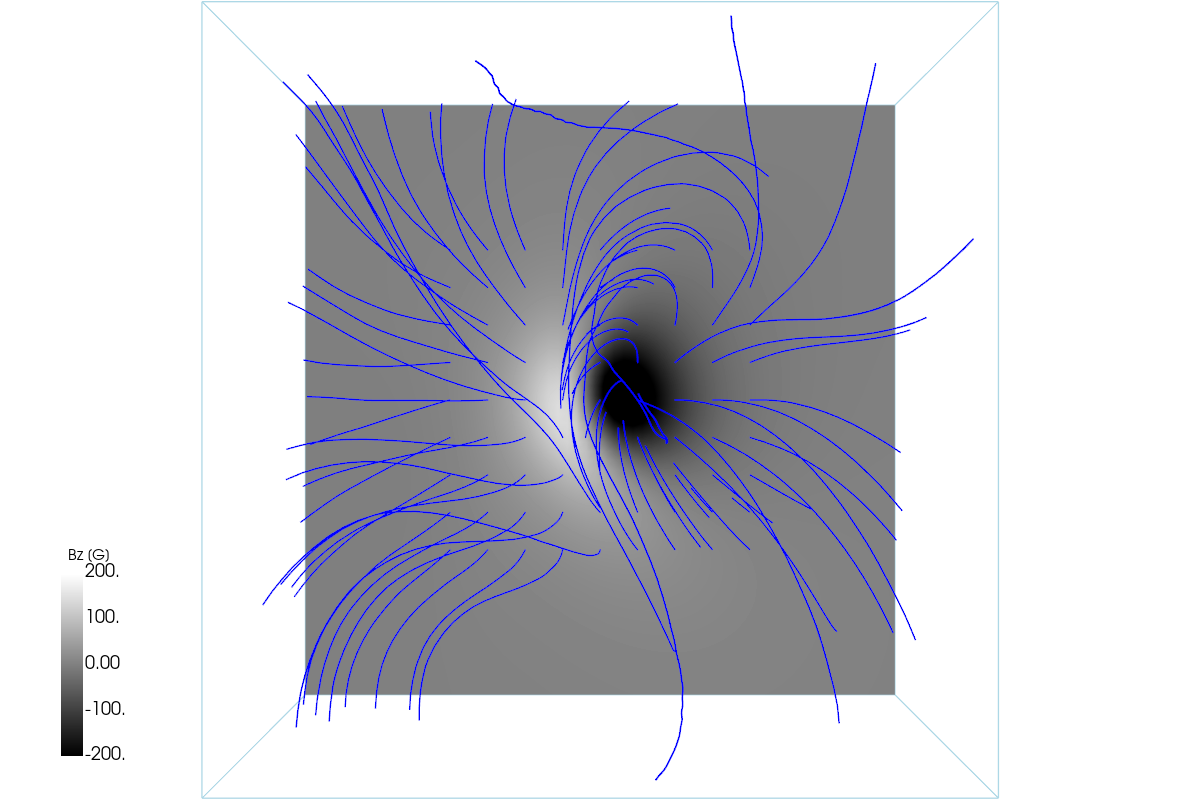

In [19]:
vmin = -200
vmax = 200
i_siz=b.shape[0] / 2
j_siz=b.shape[1] / 2
i_res=8
j_res=8
window_size=(1200, 800)
zoom=1.5
max_time=10000
camera_position = 'xy'
b_title = ''
title_fontsize = 10

bx = b[..., 0]
by = b[..., 1]
bz = b[..., 2]
mesh = create_mesh(bx, by, bz)
b_plot = mag_plotter(mesh)
b_tube, b_bottom, b_dargs = b_plot.create_mesh(i_siz=i_siz, j_siz=j_siz, i_resolution=i_res, j_resolution=j_res, vmin=vmin, vmax=vmax, max_time=max_time)


p = pv.Plotter(off_screen=False, window_size=window_size)
p.add_mesh(b_plot.grid.outline())
p.add_mesh(b_bottom, cmap='gray', **b_dargs)
p.add_mesh(b_tube, lighting=False, color='blue')
p.camera_position = camera_position
p.add_title(b_title, font_size=title_fontsize)
p.camera.zoom(zoom)
p.show()

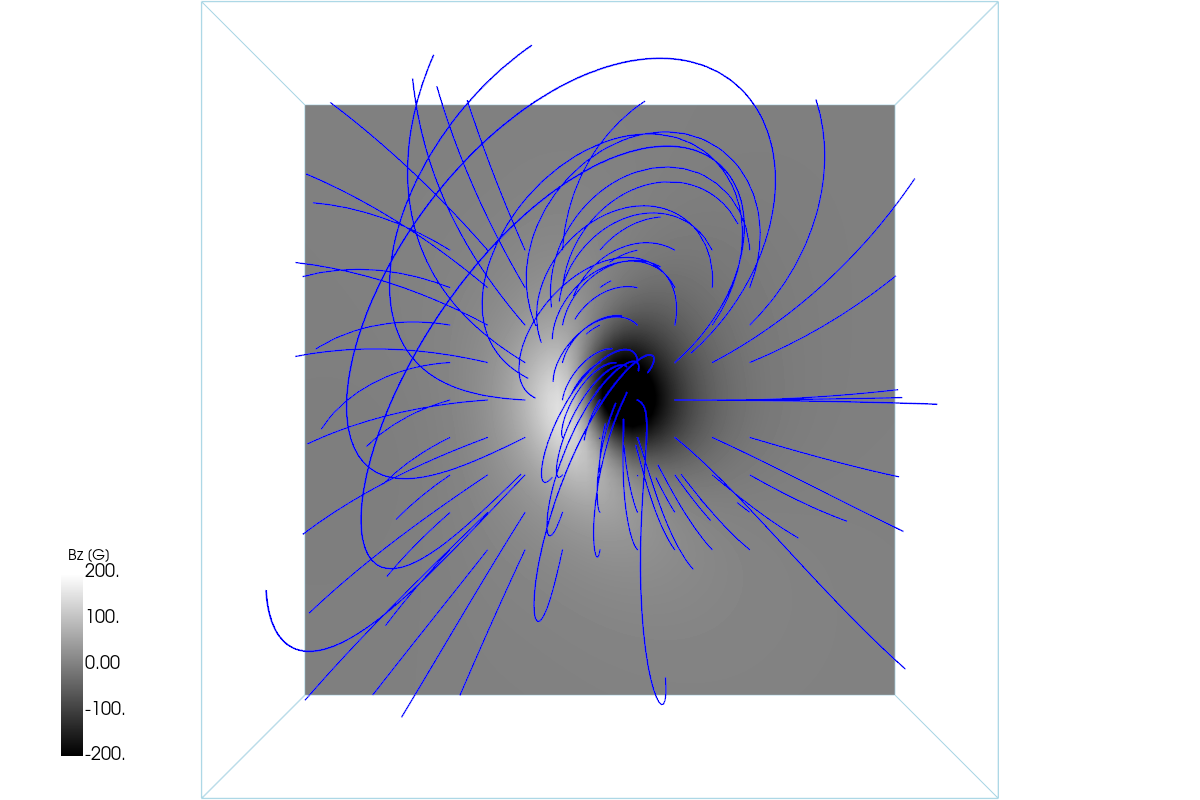

In [20]:
vmin = -200
vmax = 200
i_siz=b_cube.shape[0] / 2
j_siz=b_cube.shape[1] / 2
i_res=8
j_res=8
window_size=(1200, 800)
zoom=1.5
max_time=10000
camera_position = 'xy'
b_title = ''
title_fontsize = 10

bx = b_cube[..., 0]
by = b_cube[..., 1]
bz = b_cube[..., 2]
mesh = create_mesh(bx, by, bz)
b_plot = mag_plotter(mesh)
b_tube, b_bottom, b_dargs = b_plot.create_mesh(i_siz=i_siz, j_siz=j_siz, i_resolution=i_res, j_resolution=j_res, vmin=vmin, vmax=vmax, max_time=max_time)


p = pv.Plotter(off_screen=False, window_size=window_size)
p.add_mesh(b_plot.grid.outline())
p.add_mesh(b_bottom, cmap='gray', **b_dargs)
p.add_mesh(b_tube, lighting=False, color='blue')
p.camera_position = camera_position
p.add_title(b_title, font_size=title_fontsize)
p.camera.zoom(zoom)
p.show()

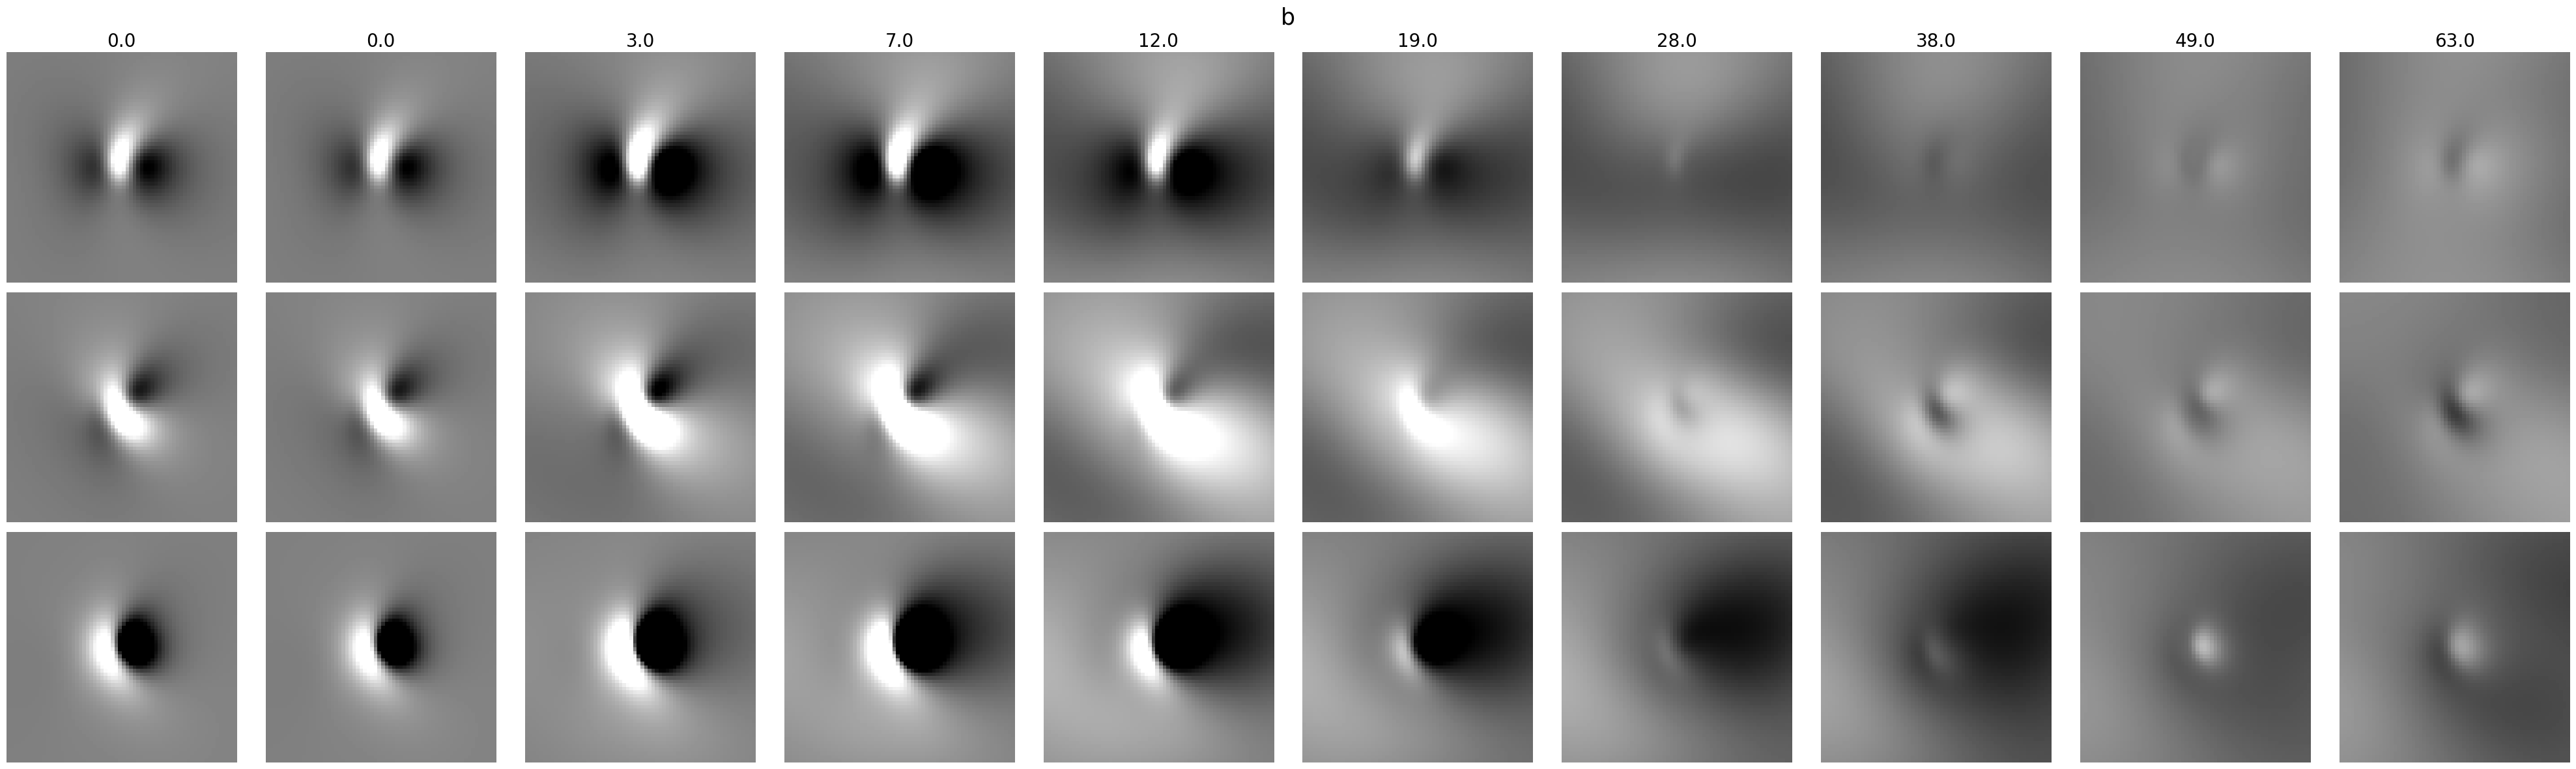

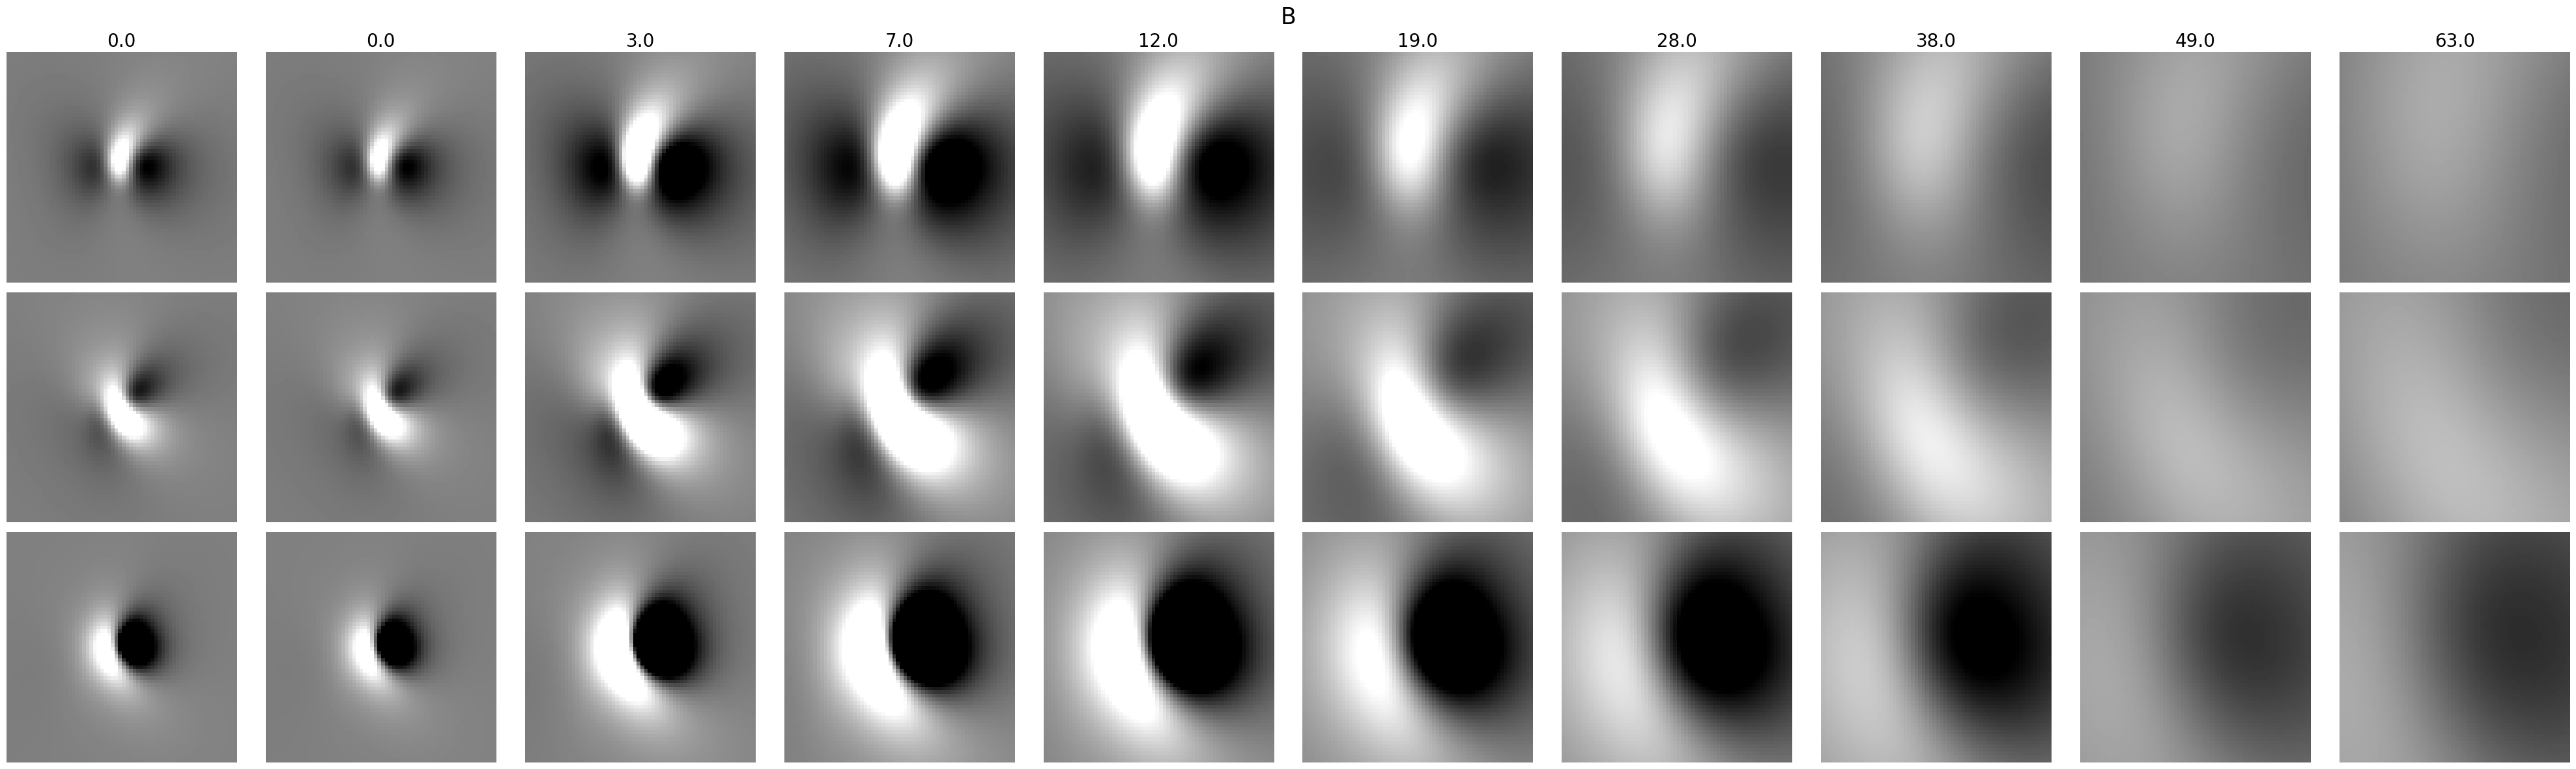

In [21]:
plot_sample(b, b_cube, v_mm=100)

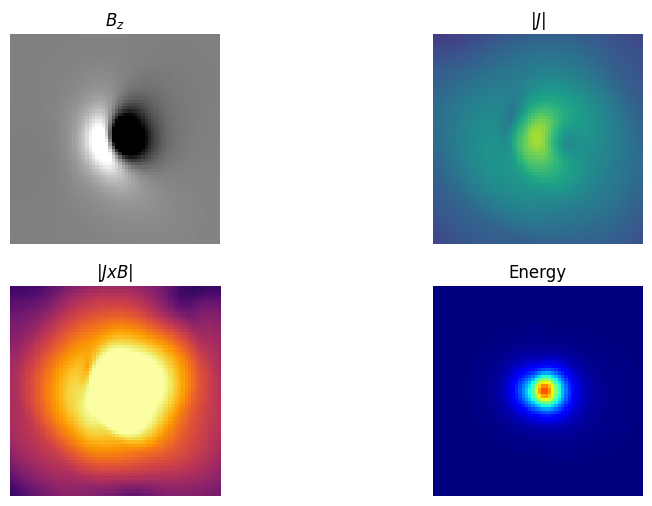

In [22]:
plot_validation(b, b_mm = [-100, 100], j_mm = [1, 1e3], jxb_mm = [1, 1e3], e_mm = [0, 1e4])

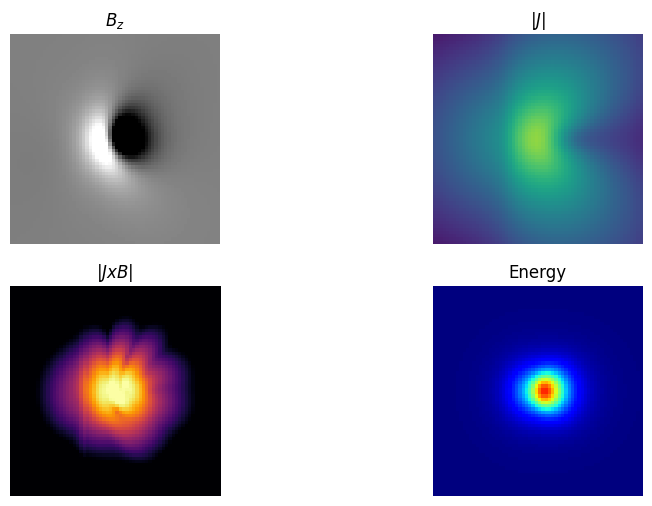

In [23]:
plot_validation(b_cube, b_mm = [-100, 100], j_mm = [1, 1e3], jxb_mm = [1, 1e3], e_mm = [0, 1e4])